> **Assignment 2 - CNN on food pictures**

> **GROUP 10**

**Group Members:**

*   Bhanu Durganath Angam
*   Samuel Anurag Prabhu Bethapudi
*   Vijaykumar Khambampati

In [35]:

import matplotlib.pyplot as plt
import matplotlib.image as img

import numpy as np
# from scipy.misc import imresize
from skimage.transform import resize as imresize

%matplotlib inline

import os
import json
from os import listdir
from os.path import isfile, join
import shutil
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
# import imread
# import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from keras.layers import Convolution2D as Conv2D, Activation, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report



os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# **Data Exploration**

Let's check
- The amount of data we have for each class
- Whether the data is balanced or not


In [2]:
# categories folders 'bbq' 'dessert' 'pasta' 'salad' 'sushi'
categories = ['bbq', 'dessert', 'pasta', 'salad', 'sushi']
num_images = defaultdict(int)
for category in categories:
    category_path = os.path.join('data', category)  # Replace 'path/to/your/folder' with the actual path to the category folder
    num_images[category] = len([f for f in listdir(category_path) if isfile(join(category_path, f))])
    print(category, num_images[category])


bbq 287
dessert 285
pasta 296
salad 293
sushi 282


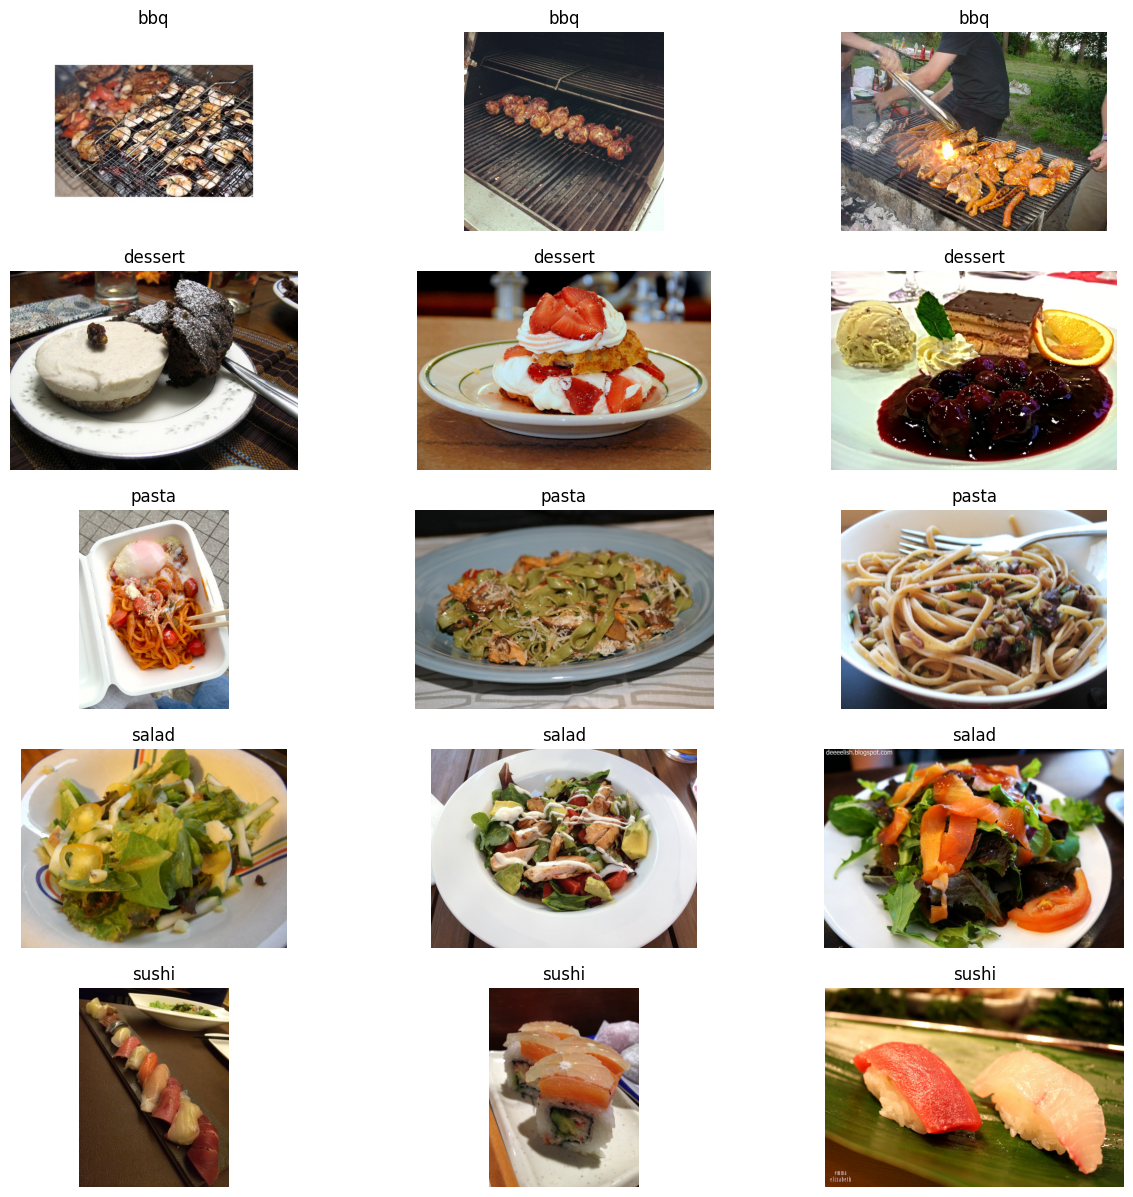

In [3]:
# randomly select 3 images from each category and show in grid
fig, ax = plt.subplots(5, 3, figsize=(15, 15))
for i, category in enumerate(categories):
    category_path = os.path.join('data', category)
    images = [f for f in listdir(category_path) if isfile(join(category_path, f))]
    for j in range(3):
        img_path = os.path.join(category_path, images[j])
        image = plt.imread(img_path)
        ax[i, j].imshow(image)
        ax[i, j].set_title(category)
        ax[i, j].axis('off')
plt.show()


Images available for each class are as follows:
 
| Category | Number of Images |
|----------|-----------------|
| bbq      | 287             |
| dessert  | 285             |
| pasta    | 296             |
| salad    | 293             |
| sushi    | 282             |

Looks like the data is nearly perfectly balanced.
BUT....

The number of images you have for each category is quite small for training a Convolutional Neural Network (CNN) from scratch. CNNs typically require large amounts of data to learn effectively without overfitting. Datasets used for training CNNs often contain thousands, if not tens of thousands, of images per category.


Inorder to tackle this small dataset problem, we can use the following techniques to train our CNN models efficiently.

# Dealing with Small Datasets in Convolutional Neural Networks

When working with Convolutional Neural Networks (CNNs), having a large dataset is often beneficial as it allows the model to learn more effectively without overfitting. However, in situations where the dataset is small, there are several techniques that can be employed to work around this limitation:

1. **Data Augmentation**

Data augmentation involves creating new training samples by applying random transformations to the existing images. These transformations can include rotation, scaling, shifting, flipping, and more. The main advantage of data augmentation is that it can significantly increase the size of the dataset and reduce the risk of overfitting by providing more varied data for the model to learn from.

2. **Transfer Learning**

Transfer learning is another effective technique for dealing with small datasets. This involves using a model that has been pre-trained on a large dataset, such as ImageNet, and fine-tuning it on the specific task at hand. The underlying idea is that the pre-trained model has already learned useful features from the large dataset that can be leveraged for the task, even though the available dataset is small.

3. **Early Stopping**

Early stopping is a form of regularization used to prevent overfitting when training a learner with an iterative method, such as gradient descent. This technique involves stopping the training process if the model's performance on a validation set stops improving for a certain number of iterations. This helps to ensure that the model does not overfit the training data by preventing it from learning too much from the noise in the data.


We are going to use all given techniques to train our model.

---

## Splitting the data 
Since the dataset is small, we will use a 80-10-10 split for the training, validation, and test sets, respectively.
- Training set: 80%
- Validation set: 10%
- Test set: 10%

In [3]:
# make train, validation and test splits for each category
for category in categories:
    category_path = os.path.join('data', category)
    train_path = os.path.join('data', 'train', category)
    valid_path = os.path.join('data', 'valid', category)
    test_path = os.path.join('data', 'test', category)
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(valid_path):
        os.makedirs(valid_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)
    image_files = [f for f in listdir(category_path) if isfile(join(category_path, f))]
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=24)  # 30% for validation and testing
    valid_files, test_files = train_test_split(test_files, test_size=0.5, random_state=24)  # Split the 30% equally into validation and testing
    for file in train_files:
        shutil.copy2(os.path.join(category_path, file), os.path.join(train_path, file))
    for file in valid_files:
        shutil.copy2(os.path.join(category_path, file), os.path.join(valid_path, file))
    for file in test_files:
        shutil.copy2(os.path.join(category_path, file), os.path.join(test_path, file))
    print(category, len(train_files), len(valid_files), len(test_files))

bbq 229 29 29
dessert 228 28 29
pasta 236 30 30
salad 234 29 30
sushi 225 28 29


| Category | Train | Valid | Test |
|----------|-------|-------|------|
| bbq      | 229   | 29    | 29   |
| dessert  | 228   | 28    | 29   |
| pasta    | 236   | 30    | 30   |
| salad    | 234   | 29    | 30   |
| sushi    | 225   | 28    | 29   |

Most frequent size of the images

In [5]:
# Initialize a dictionary to store image sizes and their frequencies
size_freq = {}

for category in categories:
    category_path = os.path.join('data', category)
    image_files = [f for f in listdir(category_path) if isfile(join(category_path, f))]
    for file in image_files:
        image_path = os.path.join(category_path, file)
        image = img.imread(image_path)
        # Get the size of the image
        size = image.shape[:2]  # We only consider the width and height, not the channels
        # Update the frequency of this size
        if size in size_freq:
            size_freq[size] += 1
        else:
            size_freq[size] = 1

# Find the size with the highest frequency
most_common_size = max(size_freq, key=size_freq.get)
print('Most common size:', most_common_size)

Most common size: (768, 1024)


---
# Data Augmentation

# For **training data** only
- Output size of the images to be 299x299 - as it is the input size for InceptionV3 model which we are going to use for transfer learning
- Using agumentation only for training data

In [4]:
# target size for the images
target_image_size = (299, 299) # InceptionV3's default target size

# Create a data generator for the training set
train_datagen = ImageDataGenerator(
    rotation_range=40,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # Set range for random shear
    zoom_range=[.8, 1],  # Set range for random zoom
    horizontal_flip=True,  # Randomly flip images
    # fill_mode='nearest'  # Set strategy for filling in newly created pixels
)

# Create a data generator for the validation set
test_datagen = ImageDataGenerator()  

# Create an iterator for the training set
train_generator = train_datagen.flow_from_directory(
    'data/train',  # Source directory for the training images
    target_size=target_image_size,  # All images will be resized to 299x299
    batch_size=32,
    class_mode='categorical'  # Since we use categorical_crossentropy loss, we need categorical labels
)

# Create an iterator for the validation set
valid_generator = test_datagen.flow_from_directory(
    'data/valid', 
    target_size=target_image_size, 
    batch_size=32,
    class_mode='categorical'
)

# Create an iterator for the test set
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=target_image_size,
    batch_size=32,
    class_mode='categorical'
)

Found 1152 images belonging to 5 classes.
Found 144 images belonging to 5 classes.
Found 147 images belonging to 5 classes.


## Check training data after augmentation

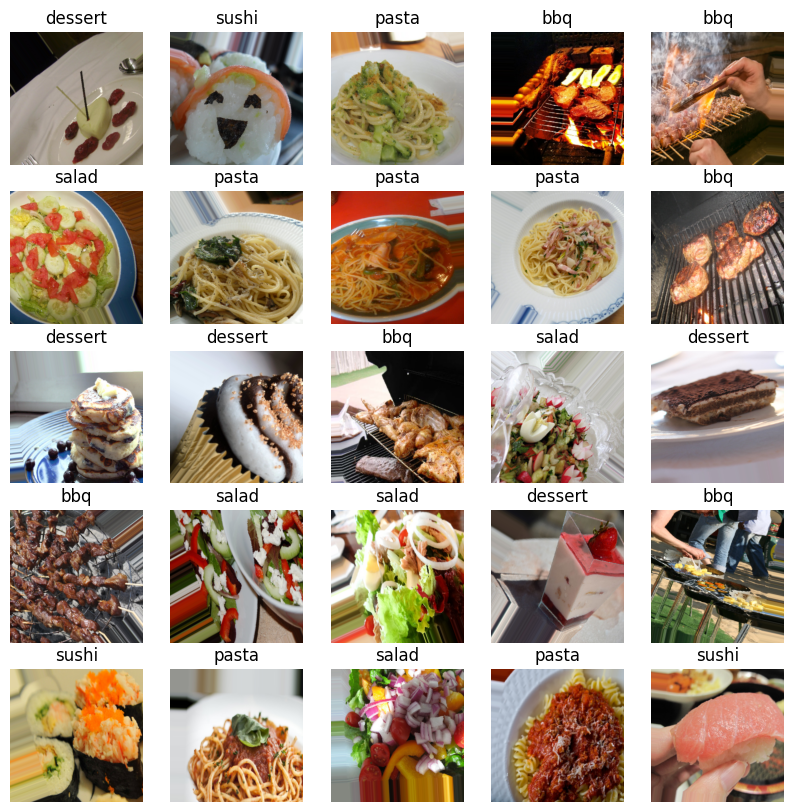

In [7]:

# view a batch of images from the training set
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(categories[np.argmax(label_batch[n])])
        plt.axis('off')


image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)




## Cheking the size of the images coming form the ImageDataGenerator

In [8]:
# check the 5 image sizes coming from the train_generator, validation_generator and test_generator
train_sizes = defaultdict(int)
valid_sizes = defaultdict(int)
test_sizes = defaultdict(int)
for i in range(5):
    x, y = train_generator.next()
    for i in range(5):
        size = x[i].shape[:2]
        train_sizes[size] += 1
    x, y = valid_generator.next()
    for i in range(5):
        size = x[i].shape[:2]
        valid_sizes[size] += 1
    x, y = test_generator.next()
    for i in range(5):
        size = x[i].shape[:2]
        test_sizes[size] += 1

print('Train sizes:', train_sizes)
print('Validation sizes:', valid_sizes)
print('Test sizes:', test_sizes)



Train sizes: defaultdict(<class 'int'>, {(299, 299): 25})
Validation sizes: defaultdict(<class 'int'>, {(299, 299): 25})
Test sizes: defaultdict(<class 'int'>, {(299, 299): 25})


# Without Transfer Learning, we will use a simple CNN model to train the data.

In [5]:
def initial_model(num_classes = 5):

    # tell the model which input shape the samples will have
    inputs = Input((299, 299, 3), dtype=np.float32)

    # first conv block, width = 16
    x = Conv2D(16, (3, 3), padding='same')(inputs)  # first layer operates on inputs
    x = Activation('relu')(x)                       # split up linear layer and activation to allow for batchnorm
    x = Conv2D(16, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # first conv block, width = 32
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # end of convolutional layers: convert remaining features to vector as input for Dense output stack
    x = Flatten()(x)

    # one hidden dense layer to show you how
    # as said during lecture: with a well-designed conv network, this may not be necessary!
    x = Dense(512)(x)
    x = Activation('relu')(x)

    # and finally the linear classification outpur layer
    output = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=output)

    # Note that, in contrast to the first graded assignment,
    # we have taken the model compilation out of this function (it is done in the model training block)

    return model

# Setting up batchsize, epochs, Optimizer and Scheduler for Learning Rate 

In [6]:
batch_size = 32
epochs = round(int(1152/batch_size)) # 1154 is the number of training images

def schedule(epoch):
    if epoch < 3:
        return 0.01
    elif epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(schedule)
# Optimizer 
opt = Adam(lr=0.01)



e:\Mstat\Deep_Learning\assignments\DL-assignments\.venv\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
# Compile the model
init_model = initial_model()
init_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Setting up Early Stopping and Model Checkpoints

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('cnn_model/without_tl/best.hdf5', monitor='val_accuracy', save_best_only=True, verbose=1)

call_backs_list = [lr_scheduler, early_stopping, model_checkpoint]

In [10]:
init_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 299, 299, 16)      448       
                                                                 
 activation_5 (Activation)   (None, 299, 299, 16)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 299, 299, 16)      2320      
                                                                 
 activation_6 (Activation)   (None, 299, 299, 16)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 149, 149, 16)      0         
 g2D)                                                            
                                                           

## training the model


In [12]:
init_model.fit(train_generator,
          validation_data=valid_generator,
          epochs=epochs,
          callbacks=call_backs_list,
          verbose=2)


Epoch 1/36

Epoch 1: val_accuracy improved from -inf to 0.20139, saving model to cnn_model/without_tl\best.hdf5


e:\Mstat\Deep_Learning\assignments\DL-assignments\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 - 52s - loss: 191.6507 - accuracy: 0.2092 - val_loss: 1.6098 - val_accuracy: 0.2014 - lr: 0.0100 - 52s/epoch - 1s/step
Epoch 2/36

Epoch 2: val_accuracy did not improve from 0.20139
36/36 - 36s - loss: 1.6110 - accuracy: 0.1936 - val_loss: 1.6092 - val_accuracy: 0.2014 - lr: 0.0100 - 36s/epoch - 1s/step
Epoch 3/36

Epoch 3: val_accuracy did not improve from 0.20139
36/36 - 36s - loss: 1.6113 - accuracy: 0.1797 - val_loss: 1.6094 - val_accuracy: 0.2014 - lr: 0.0100 - 36s/epoch - 993ms/step
Epoch 4/36

Epoch 4: val_accuracy did not improve from 0.20139
36/36 - 36s - loss: 1.6096 - accuracy: 0.2031 - val_loss: 1.6094 - val_accuracy: 0.2014 - lr: 0.0010 - 36s/epoch - 1s/step
Epoch 5/36

Epoch 5: val_accuracy did not improve from 0.20139
36/36 - 37s - loss: 1.6095 - accuracy: 0.2031 - val_loss: 1.6093 - val_accuracy: 0.2014 - lr: 0.0010 - 37s/epoch - 1s/step
Epoch 6/36

Epoch 6: val_accuracy did not improve from 0.20139
36/36 - 36s - loss: 1.6095 - accuracy: 0.2031 - val_loss: 1.6093 

In [13]:
# save model history
init_history = init_model.history.history
init_history = {key: np.array(value).tolist() for key, value in init_history.items()}
json.dump(init_history, open('cnn_model/without_tl/without_tl_history.json', 'w'))
init_history = json.load(open('cnn_model/without_tl/without_tl_history.json', 'r'))

In [14]:
# load the best model
init_model = load_model('cnn_model/without_tl/best.hdf5')

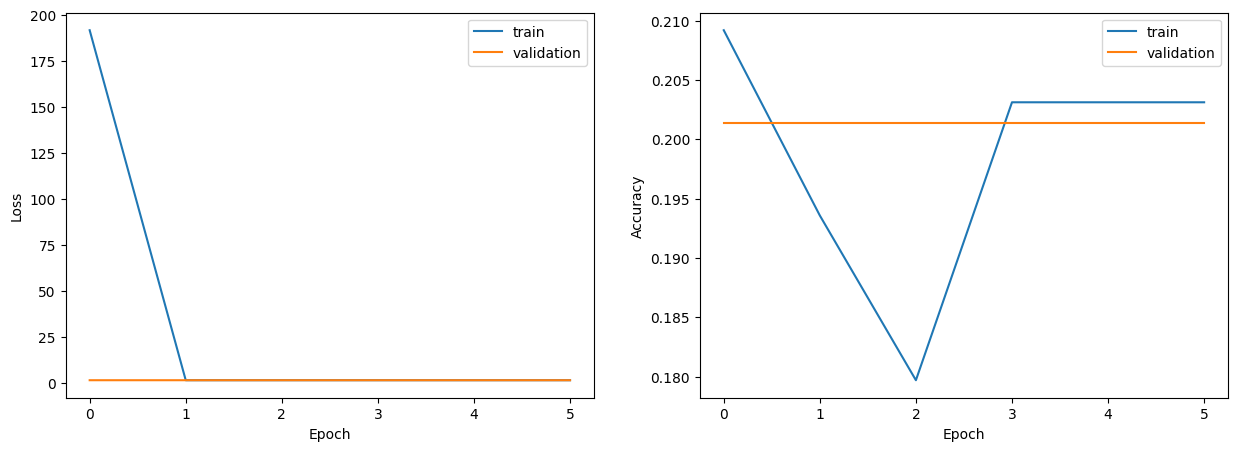

In [15]:
# check model performance plot loss and accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(init_history['loss'], label='train')
plt.plot(init_history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(init_history['accuracy'], label='train')
plt.plot(init_history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# Model evaluation on test
test_loss, test_accuracy = init_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)



5/5 [==============================] - 2s 319ms/step - loss: 1.6093 - accuracy: 0.2041
Test loss: 1.6093156337738037
Test accuracy: 0.20408163964748383


1/1 [==============================] - 0s 141ms/step


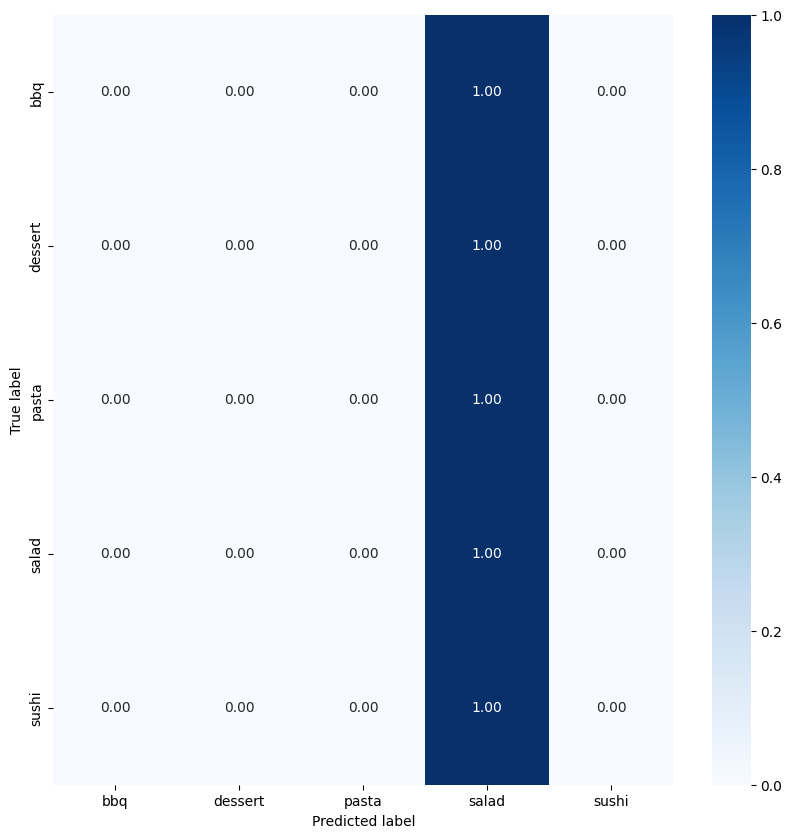

In [17]:
# Confusion matrix with out libraries
def get_predictions(model, generator):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x, y = generator[i]
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(model.predict(x), axis=1))
    return y_true, y_pred

y_true, y_pred = get_predictions(init_model, test_generator)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = sk_confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


# Transfer Learning

In [32]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(5, activation='softmax')(x)
tf_model = Model(inputs=base_model.input, outputs=x)

In [33]:
tf_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_290 (Conv2D)         (None, 149, 149, 32)         864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 149, 149, 32)         96        ['conv2d_290[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_292 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_28

In [36]:
batch_size = 32
epochs = round(int(1152/batch_size)) # 1154 is the number of training images

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

# Optimizer 
opt = Adam(learning_rate=lr_schedule, epsilon=0.1)

# Compile the model
tf_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('cnn_model/with_tl/best.hdf5', monitor='val_accuracy', save_best_only=True, verbose=1)

call_backs_list = [early_stopping, model_checkpoint]

In [38]:
tf_model.fit(train_generator,
            validation_data=valid_generator,
            epochs=epochs,
            callbacks=call_backs_list,
            verbose=2)


Epoch 1/36

Epoch 1: val_accuracy improved from -inf to 0.32639, saving model to cnn_model/with_tl\best.hdf5
36/36 - 118s - loss: 1.5637 - accuracy: 0.2925 - val_loss: 1.5610 - val_accuracy: 0.3264 - 118s/epoch - 3s/step
Epoch 2/36

Epoch 2: val_accuracy improved from 0.32639 to 0.76389, saving model to cnn_model/with_tl\best.hdf5
36/36 - 110s - loss: 1.1306 - accuracy: 0.7231 - val_loss: 0.9374 - val_accuracy: 0.7639 - 110s/epoch - 3s/step
Epoch 3/36

Epoch 3: val_accuracy improved from 0.76389 to 0.90972, saving model to cnn_model/with_tl\best.hdf5
36/36 - 112s - loss: 0.7682 - accuracy: 0.8611 - val_loss: 0.5719 - val_accuracy: 0.9097 - 112s/epoch - 3s/step
Epoch 4/36

Epoch 4: val_accuracy improved from 0.90972 to 0.95139, saving model to cnn_model/with_tl\best.hdf5
36/36 - 109s - loss: 0.5085 - accuracy: 0.9280 - val_loss: 0.3962 - val_accuracy: 0.9514 - 109s/epoch - 3s/step
Epoch 5/36

Epoch 5: val_accuracy improved from 0.95139 to 0.96528, saving model to cnn_model/with_tl\best.

In [39]:

# save model history
json.dump(tf_model.history.history, open('cnn_model/with_tl/with_tl_history.json', 'w'), default=lambda x: x.tolist())
# loading history
history = json.load(open('cnn_model/with_tl/with_tl_history.json', 'r'))


In [58]:
tf_model = load_model('cnn_model/with_tl/best.hdf5')

# Plot Model Accuracy and Loss

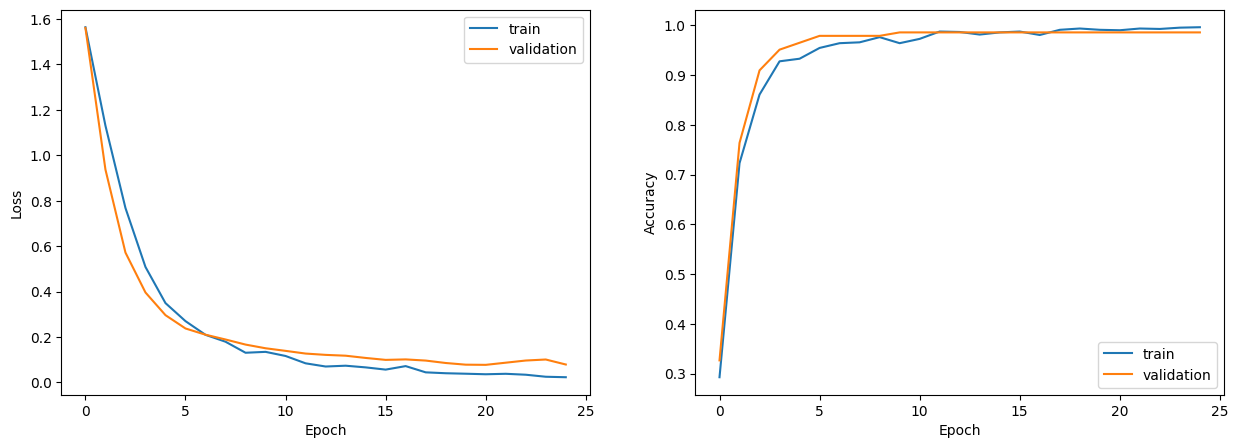

In [59]:
# check model performance plot loss and accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Testing the model with **Test data**


In [60]:
# test the model on test_generator
test_loss, test_accuracy = tf_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


5/5 [==============================] - 4s 597ms/step - loss: 0.1005 - accuracy: 0.9728
Test loss: 0.10047158598899841
Test accuracy: 0.9727891087532043


# Confusion Matrix for **Test data**


1/1 [==============================] - 1s 1s/step


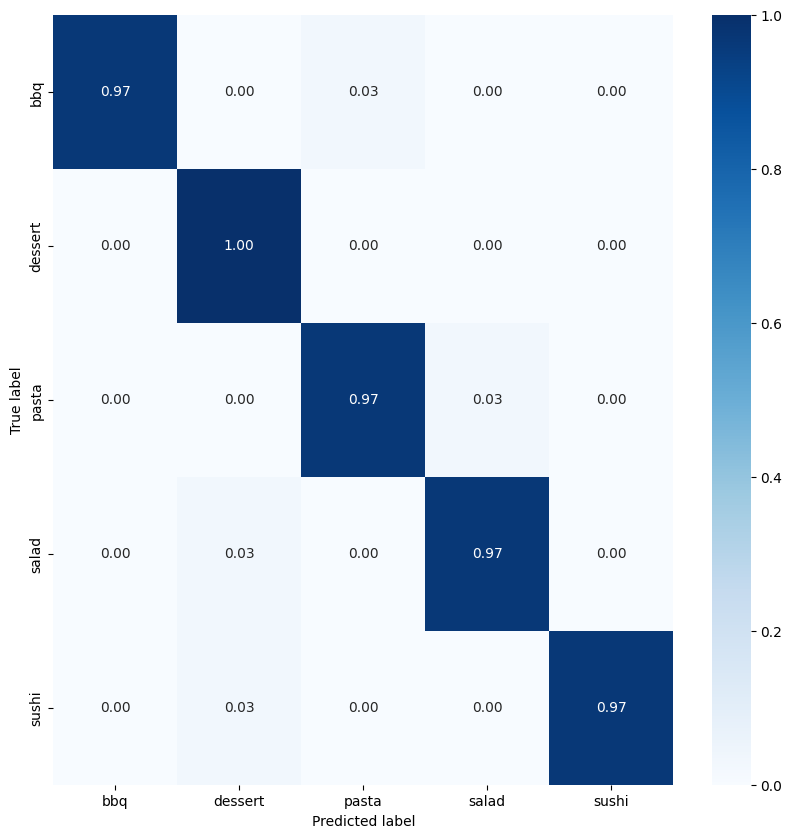

              precision    recall  f1-score   support

         bbq       1.00      0.97      0.98        29
     dessert       0.94      1.00      0.97        29
       pasta       0.97      0.97      0.97        30
       salad       0.97      0.97      0.97        30
       sushi       1.00      0.97      0.98        29

    accuracy                           0.97       147
   macro avg       0.97      0.97      0.97       147
weighted avg       0.97      0.97      0.97       147



In [61]:
# Confusion matrix

y_true, y_pred = get_predictions(tf_model, test_generator)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = sk_confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=categories))



1/1 [==============================] - 0s 388ms/step
[101  67  23  84]


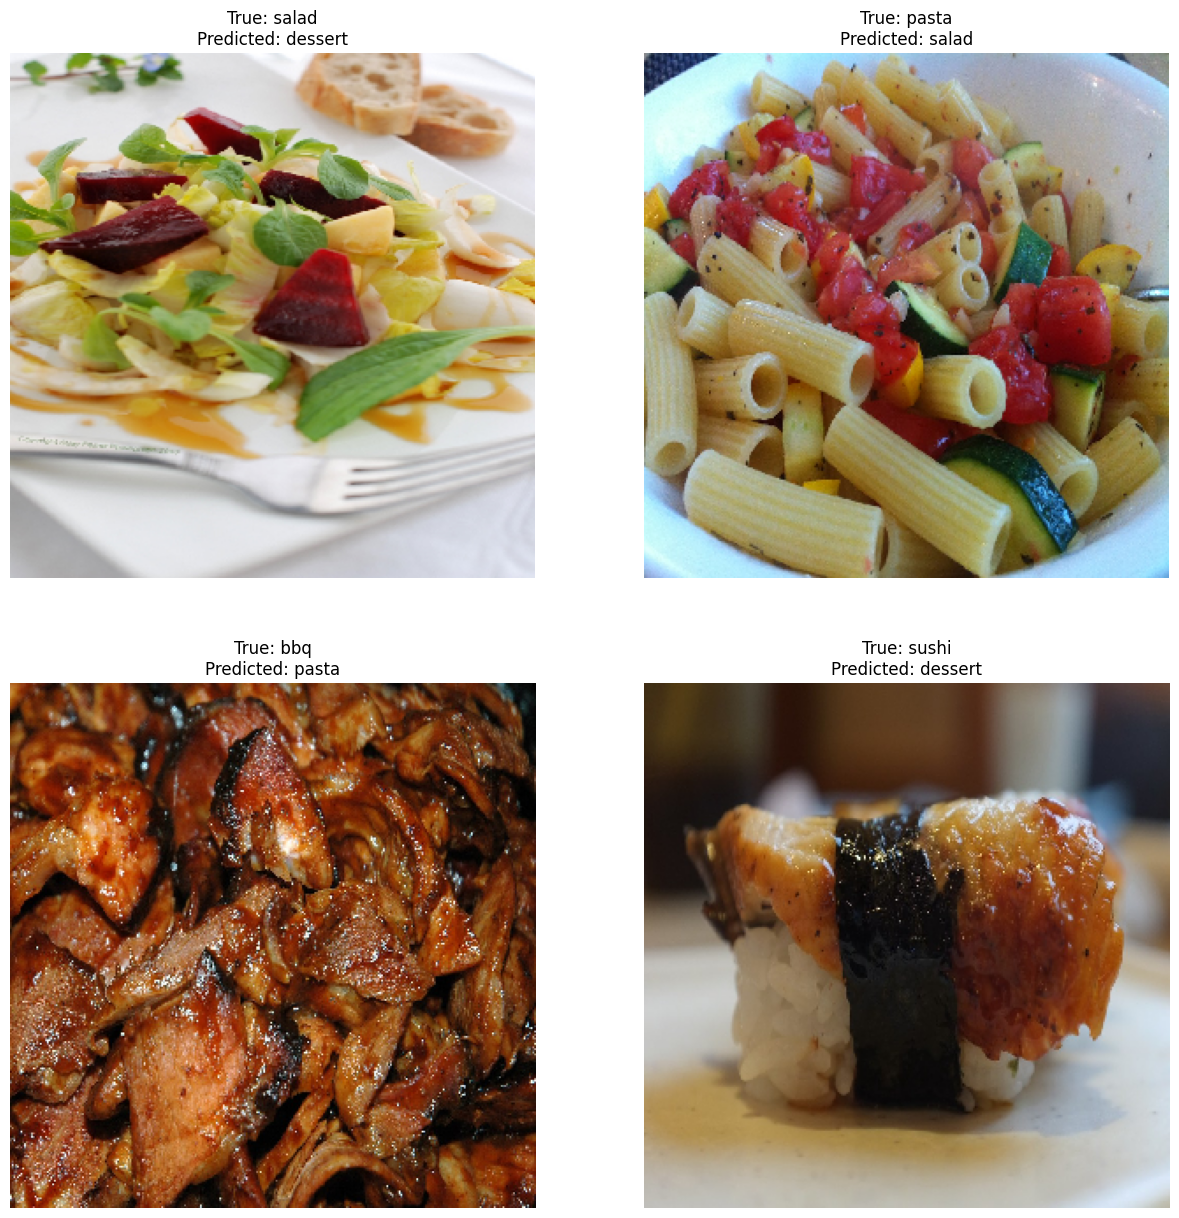

In [70]:
# Plot False predictions for all categories of the model if exists only
def plot_false_predictions(model, generator, categories):
    y_true, y_pred = get_predictions(model, generator)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    false_indices = np.where(y_true != y_pred)[0]
    if len(false_indices) < 25:
        sample_size = len(false_indices)
    else:
        sample_size = 25
    false_indices = np.random.choice(false_indices, size=sample_size, replace=False)
    print(false_indices)
    fig, ax = plt.subplots(2, 2, figsize=(15, 15))

    for i, index in enumerate(false_indices):
        batch_index = index // generator.batch_size
        image_index = index % generator.batch_size
        image = generator[batch_index][0][image_index]
        label = categories[y_true[index]]
        prediction = categories[y_pred[index]]
        ax[i // 2, i % 2].imshow(image/255.0)
        ax[i // 2, i % 2].set_title(f'True: {label}\nPredicted: {prediction}')
        ax[i // 2, i % 2].axis('off')
    plt.show()  

plot_false_predictions(tf_model, test_generator, categories)



# Interpretability of the model

In [71]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

  0%|          | 0/1000 [00:00<?, ?it/s]

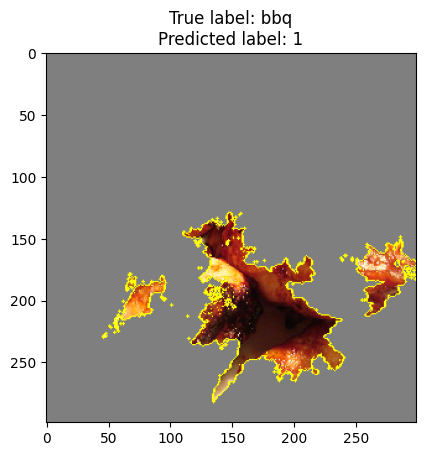

  0%|          | 0/1000 [00:00<?, ?it/s]

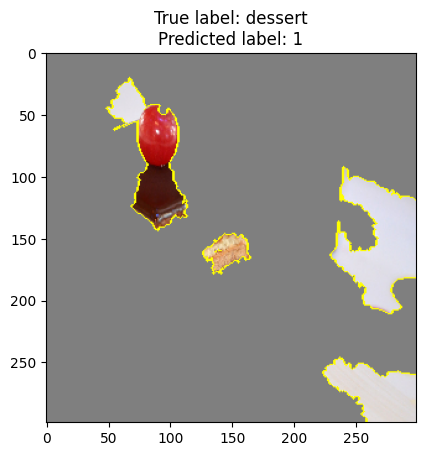

  0%|          | 0/1000 [00:00<?, ?it/s]

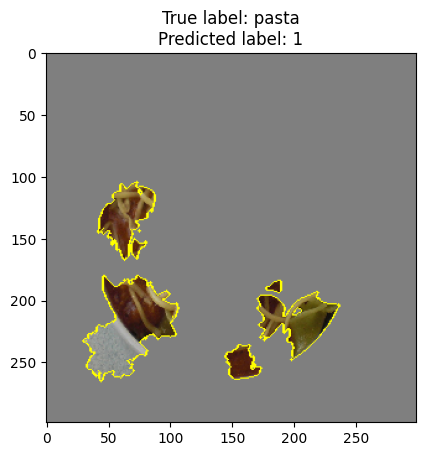

  0%|          | 0/1000 [00:00<?, ?it/s]

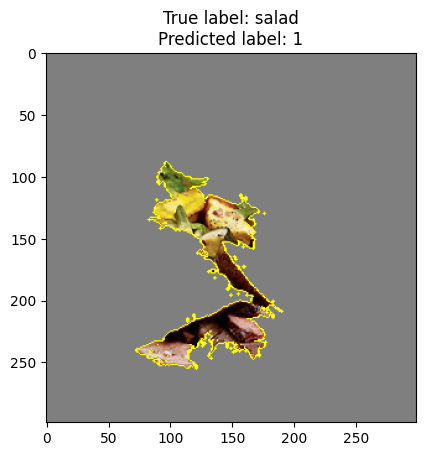

  0%|          | 0/1000 [00:00<?, ?it/s]

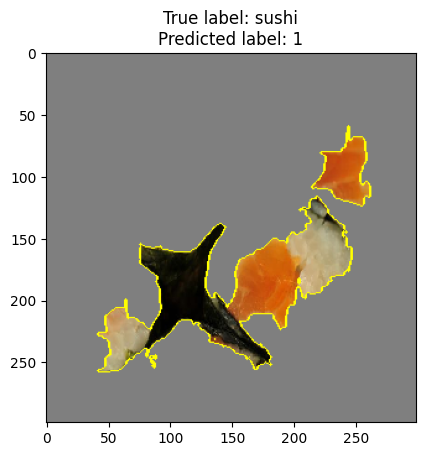

In [76]:
from keras.preprocessing import image
import random

# Create a LimeImageExplainer
explainer = lime_image.LimeImageExplainer()

# Define a prediction function
def model_predict(img):
    return tf_model.predict(img, verbose=0)

# Get the list of subdirectories (each subdirectory corresponds to a class)
class_dirs = os.listdir('data/valid/')

# For each class directory
for class_dir in class_dirs:
    # Get the list of image files in the class directory
    image_files = os.listdir(os.path.join('data/valid/', class_dir))
    
    # Select one image randomly
    selected_image = random.choice(image_files)
    
    # Load the image
    img_path = os.path.join('data/valid/', class_dir, selected_image)
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Explain the prediction
    explanation = explainer.explain_instance(x[0].astype('double'), model_predict, top_labels=5, hide_color=0, num_samples=1000)

    # Display the image and the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title(f'True label: {class_dir}\nPredicted label: {explanation.top_labels[0]}')
    plt.show()